## Q-Learning with Value Function Approximation

Here is the implementation of Q-Learning with VFA, an off-policy control algorithm. Experiments are performed on openai.gym MountainCar-v0 environment.

In [0]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import sys
import gym
from gym import logger as gymlogger
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

## MountainCar environment

- A state is a tuple of current distance and velocity ($x_t, v_t$)
\begin{align*}
    v_{t+1} &= bound(v_t + 0.001 A_t - 0.0025 cos(3 x_t))\\
    x_{t+1} &= bound(x_t + v_{t+1})
\end{align*}
Here $bound$ operator enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le v_{t+1} \le 0.07$

- Action is one of 3 possible choices - full throttle forward (+1), full throttle reverse (-1) and zero throttle (0)

In [0]:
env_mc = gym.make("MountainCar-v0").env
print(env_mc.observation_space)
print(env_mc.action_space)

Box(2,)
Discrete(3)


## Construction of features
- Features are created using RBF sampler
- Also defined a value function approximator $\hat{q}$ for approximating $q$-values

In [0]:
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

observation_examples = np.array([env_mc.observation_space.sample() for x in range(10000)])
action_examples = np.array([env_mc.action_space.sample() for x in range(10000)]).reshape((10000,1))
sa_examples = np.append(observation_examples, action_examples, axis=1)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(sa_examples)

# A featurizer to convert (state,action) pairs to features x(S,A) = [x1(S,A),..., xd(S,A)]^T
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(sa_examples))
num_features = 400

def get_feature_vector(env, state, action=None):
    """
    - Get feature vector for (state,action) pair x(S,A)
    - If action=None, return feature matrix corresponding to (state,.)
    """
    if action is not None:
        sa_pairs = [np.append(state, [action])]
    else:
        num_actions = env.action_space.n
        sa_pairs = np.append(np.array([state,]*num_actions), np.array(range(num_actions)).reshape((num_actions,1)), axis=1)
    return featurizer.transform(scaler.transform(sa_pairs))

In [0]:
class VFA:
    def __init__(self, env):
        self.env = env
        self.weights = np.zeros((num_features,))
        self.feature_function = get_feature_vector
    
    def estimate_q_values(self, state, action=None):
        """
        - Function to get the approximate value q_hat(s,a,w)
        - If action=None, then return a vector of q_values for all actions
        - This is implemented as linear VFA
        """
        feature_vector = self.feature_function(self.env,state,action)
        return np.dot(feature_vector,self.weights)

## Implementation of Semi-gradient Q-learning

In [0]:
def get_epsilon_greedy_policy(estimator, epsilon=0.1):
    """
    Make an epsilon-greedy policy from given Q-values
    Args:
        estimator: The VFA to use used to get approximate values
        epsilon: epsilon value for making the epsilon greedy policy

    Returns:
        policy: epsilon-greedy policy which takes random action with
                probability epsilon/num_actions, otherwise takes
                greedy action
    """
    def policy(state):
        q_values = estimator.estimate_q_values(state)
        num_actions = len(q_values)
        greedy_action = q_values.argmax()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

In [0]:
def q_learning_vfa(env, num_episodes=10000, gamma=1.0, alpha=0.015, epsilon=0.1):
    """
    Performs semi-gradient Q-learning control

    Args:
        env: Learning enviroment, e.g. Blackjack
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        alpha: Step size / learning rate
        epsilon: epsilon to used for making epsilon-greedy policy.
    Returns:
        estimator: Optimal Value function approximator
        stats: algorithm learning statistics
    """

    num_actions = env.action_space.n
    estimator = VFA(env)
    policy = get_epsilon_greedy_policy(estimator, epsilon)
    stats = {'episode_lengths': [0 for _ in range(num_episodes)],
             'episode_returns': [0 for _ in range(num_episodes)]}

    for episode_num in range(num_episodes):
        if (episode_num+1) % 10 == 0:
            print("\rFinished {}/{} episodes".format(episode_num+1,num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()

        while True: # Until eipsode finishes
            # Choose action based on above policy
            action_probs = policy(state)
            action = np.random.choice(np.arange(num_actions), p=action_probs)
            # Take action
            next_state, reward, done, info = env.step(action)

            # Q-learning target to update weights
            q_target = reward
            if not done:
                next_q_values = estimator.estimate_q_values(next_state)
                q_target += gamma * np.max(next_q_values)
            
            # Update approximator weights using semi-gradient Q-learning SGD update
            curr_q_value = estimator.estimate_q_values(state)[action]
            feature_vector = get_feature_vector(env, state, action)[0]
            estimator.weights = estimator.weights + alpha * (q_target - curr_q_value) * feature_vector

            policy = get_epsilon_greedy_policy(estimator, epsilon)
            state = next_state

            # Update stats
            stats['episode_returns'][episode_num] += reward
            stats['episode_lengths'][episode_num] += 1
            
            if done: break

    policy = get_epsilon_greedy_policy(estimator, 0.0)
    return estimator, policy, stats

In [0]:
estimator_mc, policy_mc, stats_mc = q_learning_vfa(env_mc, num_episodes=100, gamma=1.0, alpha=0.03, epsilon=0.1)

Finished 100/100 episodes

## Plot training results

In [0]:
def plot_stats_mc(stats):
    episode_returns = pd.Series(stats['episode_returns']).rolling(20).mean()
    episode_lengths = pd.Series(stats['episode_lengths'])
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(episode_returns)
    ax1.set_title("Episode returns over time (smoothing window = 20)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total reward in Episode ")

    ax2.plot(episode_lengths)
    ax2.set_title("Episode lenghts over time")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Episode length")
    plt.show()

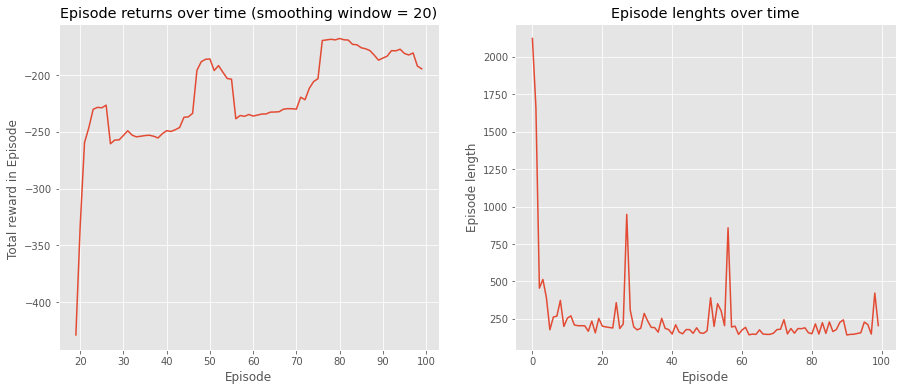

In [0]:
plot_stats_mc(stats_mc)

## Visualizing the learned policy

By looking at above plots, semi-gradient Q-learning seems to be doing well in MountainCar environment. Let's now render the learned policy and take a look at the optimal policy in action.

In [0]:
!apt-get install -y xvfb python-opengl x11-utils ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
from gym.wrappers import Monitor
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display_params = display.start()

In [0]:
# This function to render gym environment in colab is taken from
# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
def show_policy_episode(gym_env, policy):
    env = wrap_env(gym_env)
    state = env.reset()
    final_score = 0
    for t in range(1000):
        env.render()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, info = env.step(action)
        final_score += reward
        state = next_state
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("Final Score: {}".format(int(final_score)))
            break
    env.close()
    show_video()

In [0]:
show_policy_episode(env_mc, policy_mc)

Episode finished after 152 timesteps
Final Score: -152
